In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import treecorr

In [2]:
NSIDE = 2**11
npix_healpy = hp.nside2npix(nside=NSIDE)
print(npix_healpy)

50331648


In [3]:
npix = 12*NSIDE**2 # write the relevant equation from the manual and compare the value of npix with npix_healpy above
print(npix)

50331648


In [4]:
map_arr = np.arange(npix)
print(map_arr)

[       0        1        2 ... 50331645 50331646 50331647]


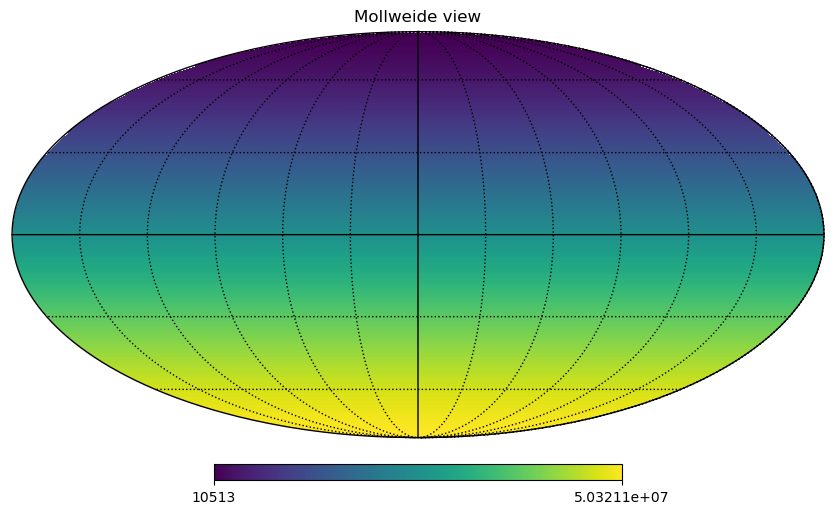

In [5]:
hp.mollview(map_arr)
hp.graticule()
plt.show()

In [6]:
pix_area_healpy = hp.nside2pixarea(NSIDE) 
pix_area_healpy

2.4967135219492856e-07

In [7]:
pix_area_manual = npix * 1/(4*np.pi)
pix_area_healpy

2.4967135219492856e-07

In [8]:
NSIDE_vals = [2**1,2**2,2**3,2**(11)]
npix_vals =[]
pix_area_manual_vals = []
for nside_vals in NSIDE_vals:
    n_pix_vals = 12*nside_vals**2
    pix_area_manual = n_pix_vals * 1/(4*np.pi)
    npix_vals.append(n_pix_vals)
    pix_area_manual_vals.append(pix_area_manual)
    
    
print(npix_vals) 
print(pix_area_manual_vals)

[48, 192, 768, 50331648]
[3.819718634205488, 15.278874536821952, 61.11549814728781, 4005265.286580654]


<Figure size 1200x800 with 0 Axes>

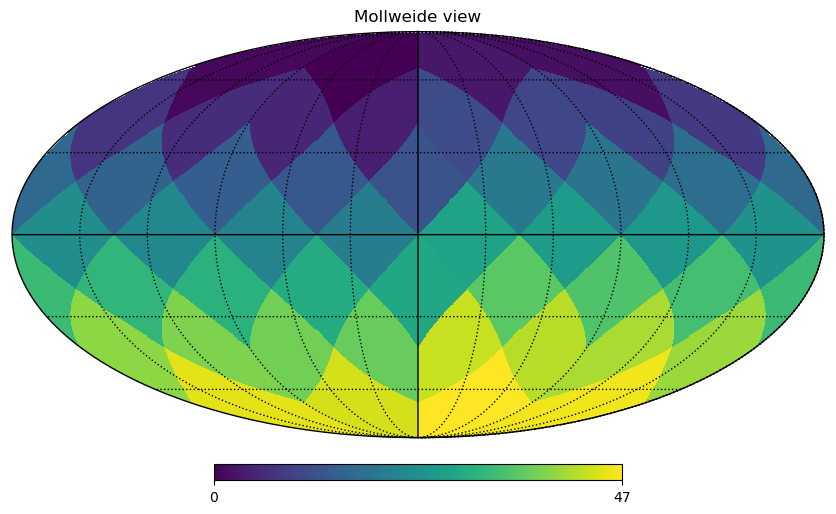

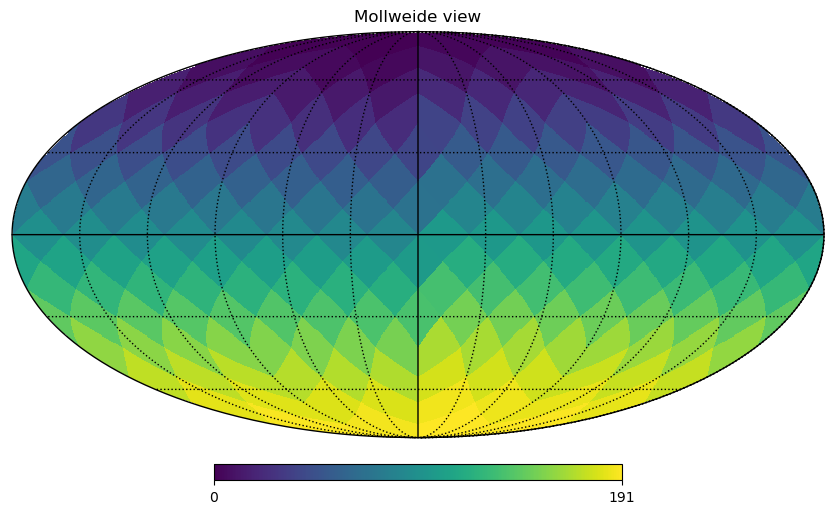

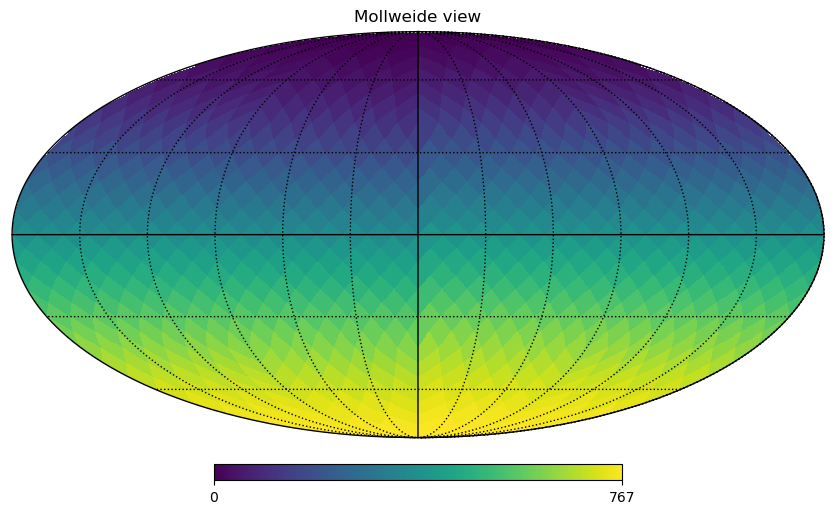

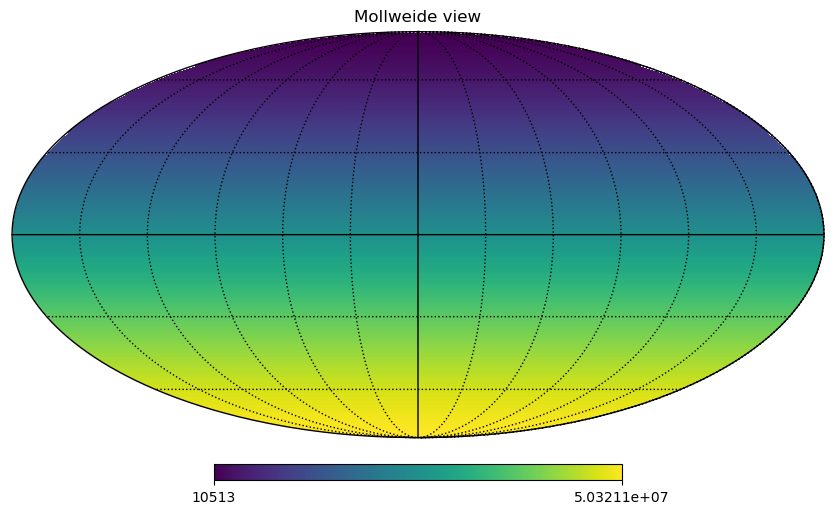

In [9]:
plt.figure(figsize=(12, 8))

for i, nside in enumerate(NSIDE_vals):
    npix = hp.nside2npix(nside)
    map_arr = np.arange(npix)
    # Use the sub parameter: (nrows, ncols, plot_number)
    hp.mollview(map_arr)
    hp.graticule()
    plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------

# P2.2

total pixels in disc =50331648
total pixels in selected patch =23948


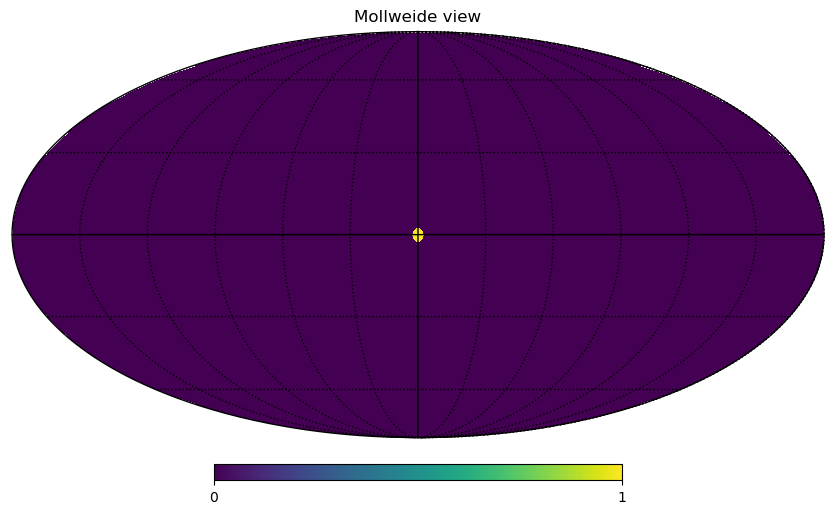

In [10]:
NSIDE_fix = NSIDE_vals[3]
#choose patch radius:
radius_degree =  2.5
radius_rad = np.radians(radius_degree)
#center = 0 (north pole) and pi/2 (equator), need in radians
thetha_center = 0
phi_center = 0
#convert this to a 3D unit vector
vec_center = hp.ang2vec(thetha_center, phi_center, lonlat=True) #lonlat = True = lon lat given in degrees
# Find all the pixels within the defined angular radius
pix_in_disc = hp.query_disc(NSIDE_fix , vec_center , radius_rad , inclusive= False)
# Make a map highlighting the selected patch
map_disc = np.zeros(hp.nside2npix(NSIDE_fix))
#all pixels inside selected patch = 1, others 0
map_disc[pix_in_disc] = 1
print(f'total pixels in disc ={hp.nside2npix(NSIDE_fix)}')
print(f'total pixels in selected patch ={len(pix_in_disc)}')
#mollview
hp.mollview(map_disc)
hp.graticule()
plt.show()

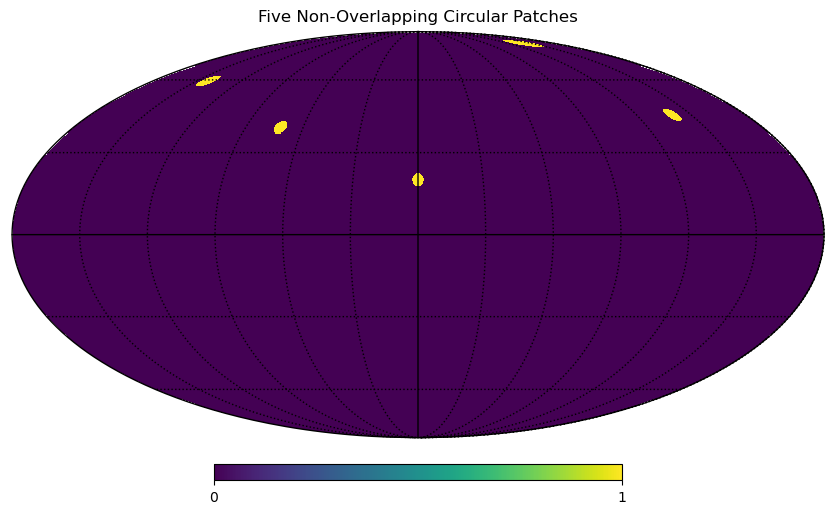

In [11]:
#latitude = thetha between - + 90
theta_degs = [20, 40, 60, 80, 45]
phi_degs = [0, 72, 144, 216, 220]  # spread around longitude

map_multi = np.zeros(hp.nside2npix(NSIDE_fix))

for t_deg, p_deg in zip(theta_degs, phi_degs):
    vec = hp.ang2vec(p_deg, t_deg, lonlat=True)
    disc_pix = hp.query_disc(NSIDE_fix, vec, radius_rad)
    map_multi[disc_pix] = 1

hp.mollview(map_multi, title="Five Non-Overlapping Circular Patches")
hp.graticule()
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------

# P2.3

Number of pixels: 50331648
NSIDE: 2048


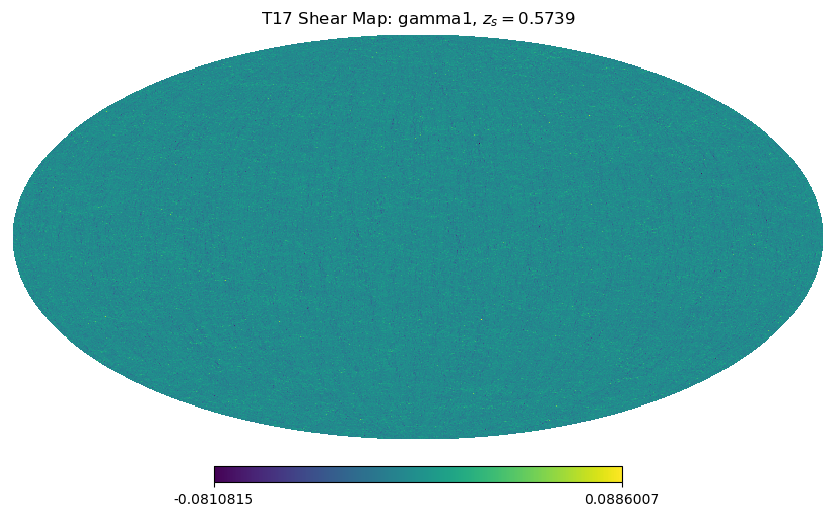

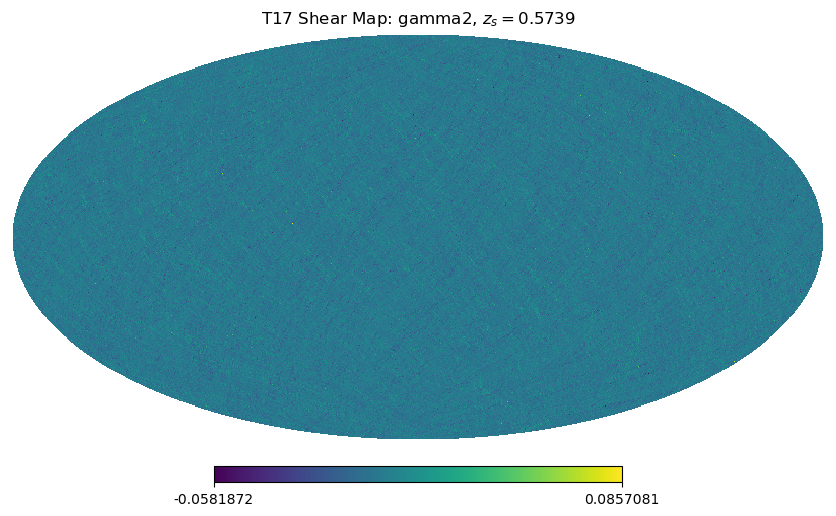

In [12]:
gamma1_file_1 = "T17_simulation_WL_shear_data/allskymap_NSIDE2048_r000_zsource_0.5739_gamma1.fits"
gamma2_file_1 = "T17_simulation_WL_shear_data/allskymap_NSIDE2048_r000_zsource_0.5739_gamma2.fits"

# Load the maps using healpy
gamma1_map_1 = hp.read_map(gamma1_file_1)
gamma2_map_1 = hp.read_map(gamma2_file_1)

# Check the number of pixels and corresponding NSIDE
npix = len(gamma1_map_1)
nside = hp.npix2nside(npix)
print(f"Number of pixels: {npix}")
print(f"NSIDE: {nside}")

# Visualize the maps
hp.mollview(gamma1_map_1, title="T17 Shear Map: gamma1, $z_s=0.5739$")
plt.show()

hp.mollview(gamma2_map_1, title="T17 Shear Map: gamma2, $z_s=0.5739$")
plt.show()

In [13]:
print(len(gamma1_map_1))
print(hp.npix2nside(len(gamma1_map_1)))

50331648
2048


-----------------------------------------------------------------------------------------------------------------------------------------------------

# P2.4

In [14]:
def pixel2RaDec(pixel_indices, NSIDE):
    theta, phi = hp.pixelfunc.pix2ang(NSIDE, pixel_indices, nest=False,lonlat=False)
    ra = phi
    dec = np.pi/2.0-theta
    return ra, dec
ra_rad, dec_rad = pixel2RaDec(pix_in_disc, NSIDE_fix)
#ra_deg = np.degrees(ra_rad)
#dec_deg = np.degrees(dec_rad)
#associated gamma1 and gamma2 from extracted pixels
gamma1_disc_1 = gamma1_map_1[pix_in_disc]
gamma2_disc_1 = gamma2_map_1[pix_in_disc]

print(len(gamma1_disc_1))
print(gamma2_disc_1)

23948
[0.00466651 0.00147077 0.00316822 ... 0.0007352  0.00786598 0.0021285 ]


In [15]:
cat_1 = treecorr.Catalog(ra = ra_rad, dec = dec_rad , g1 = gamma1_disc_1 , g2 = gamma2_disc_1 , ra_units = 'rad' , dec_units = 'rad' , flip_g1 = True )

In [16]:
print("Tree catalog created with" , cat_1.nobj, "objects")

Tree catalog created with 23948 objects


In [17]:
#create 20 equally spaced logarithmic bins 
min_sep = 5
max_sep = 140
nbins = 20
#gg correlation object
#gg_1 = treecorr.GGCorrelation(min_sep = min_sep , max_sep = max_sep, nbins = nbins, sep_units = "radians")
gg_1 = treecorr.GGCorrelation(min_sep = 5*np.pi/(180*60), max_sep = 140*np.pi/(180*60),nbins = 20 ,sep_units = 'radians')

In [18]:
#compute the correlation function
gg_1.process(cat_1)

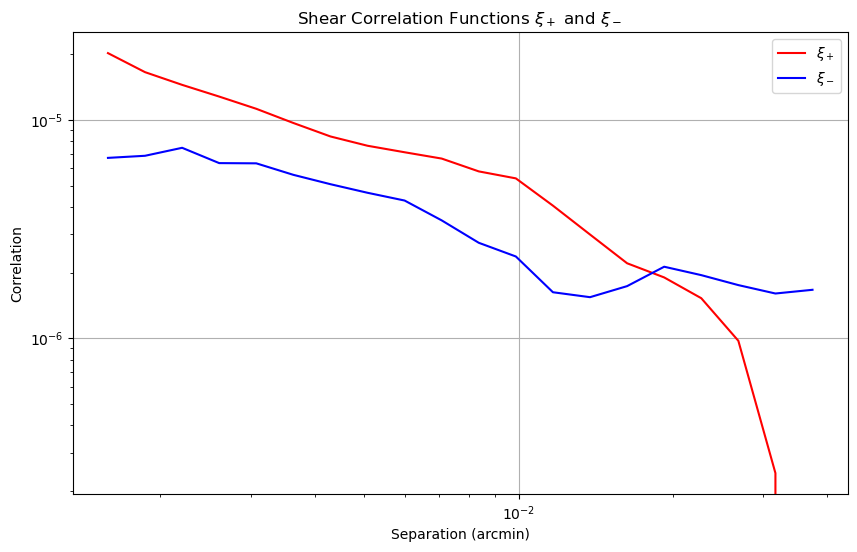

In [19]:
#gg.xip and gg.xim are correlation values eta+ eta-
xip_values_1 = gg_1.xip
xim_values_1 = gg_1.xim
rnom_values_1 = gg_1.rnom # gives normal bin centers (angular seperations)
#correlation function v/s angular separations
plt.figure(figsize=(10,6))
plt.plot(rnom_values_1, xip_values_1 ,c='r', label=r'$\xi_+$')
plt.plot(rnom_values_1, xim_values_1, c='b', label=r'$\xi_-$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel('Correlation')
plt.title('Shear Correlation Functions $\\xi_+$ and $\\xi_-$')
plt.legend()
plt.grid(True)
plt.show()
#If your selected patch is small or contains random shear values (as can happen in a small disc or a
#region with little signal), the correlation functions eta+and eta− will average to zero.

------------------------------------------------------------------------------------------------------------------------------------------------------

# P2.5

In [20]:
n_patches = 100
nbins = 20

# Arrays to store results
xip_arr = np.zeros((n_patches, nbins))
xim_arr = np.zeros((n_patches, nbins))

# Randomly select patch centers (latitude in [-87.5, 87.5] to avoid poles)
rng = np.random.default_rng(seed=42)
latitudes = rng.uniform(-87.5, 87.5, n_patches)
longitudes = rng.uniform(0, 360, n_patches)

for i in range(n_patches):
    lat = latitudes[i]
    lon = longitudes[i]
    vec = hp.ang2vec(lon, lat, lonlat=True)
    pix_in_disc = hp.query_disc(NSIDE_fix, vec, radius_rad, inclusive=False)

    # Convert pixel indices to RA/Dec (degrees)
    theta, phi = hp.pix2ang(NSIDE_fix, pix_in_disc, lonlat=False)
    ra = phi
    dec = 0.5 * np.pi - theta

    # Extract shear values for the patch
    g1_1 = gamma1_map_1[pix_in_disc]
    g2_1 = gamma2_map_1[pix_in_disc]

    # Build TreeCorr catalog
    cat_1 = treecorr.Catalog(ra=ra, dec=dec, g1=g1_1, g2=g2_1, ra_units='rad', dec_units='rad', flip_g1=True)
    gg_1 = treecorr.GGCorrelation(min_sep = 5*np.pi/(180*60), max_sep = 140*np.pi/(180*60),nbins = 20 ,sep_units = 'radians')
    gg_1.process(cat_1)

    xip_arr[i, :] = gg_1.xip
    xim_arr[i, :] = gg_1.xim

print("xip_arr shape:", xip_arr.shape)
print("xim_arr shape:", xim_arr.shape)


xip_arr shape: (100, 20)
xim_arr shape: (100, 20)


In [21]:
xip_mean_1 = np.mean(xip_arr, axis=0)
xip_std_1 = np.std(xip_arr, axis=0)
xim_mean_1 = np.mean(xim_arr, axis=0)
xim_std_1 = np.std(xim_arr, axis=0)

print("Mean xi_+:", xip_mean_1)
print("Std xi_+:", xip_std_1)
print("Mean xi_-:", xim_mean_1)
print("Std xi_-:", xim_std_1)

Mean xi_+: [2.11534634e-05 1.79024059e-05 1.55330784e-05 1.32331730e-05
 1.13420679e-05 9.78228560e-06 8.49062800e-06 7.40819071e-06
 6.53633074e-06 5.73625304e-06 5.00090779e-06 4.33220783e-06
 3.71795750e-06 3.13838042e-06 2.64944616e-06 2.22542023e-06
 1.75480708e-06 1.31565804e-06 1.06035637e-06 8.19579073e-07]
Std xi_+: [5.83494385e-06 5.10366556e-06 4.43586155e-06 3.86081418e-06
 3.42759999e-06 3.06905748e-06 2.78993635e-06 2.59503665e-06
 2.43437785e-06 2.33058777e-06 2.21850279e-06 2.08746599e-06
 1.93123104e-06 1.85711216e-06 1.75744013e-06 1.70508635e-06
 1.68238674e-06 1.50000166e-06 1.39919329e-06 1.35498578e-06]
Mean xi_-: [6.98771230e-06 7.27547662e-06 7.09683087e-06 6.82715569e-06
 6.42938613e-06 5.96252592e-06 5.38456905e-06 4.82102635e-06
 4.25544307e-06 3.66730492e-06 3.14413289e-06 2.70624887e-06
 2.34011531e-06 2.02226432e-06 1.79366315e-06 1.57501555e-06
 1.35016636e-06 1.19390087e-06 1.16559396e-06 1.05606274e-06]
Std xi_-: [1.34910076e-06 1.38089667e-06 1.4164553

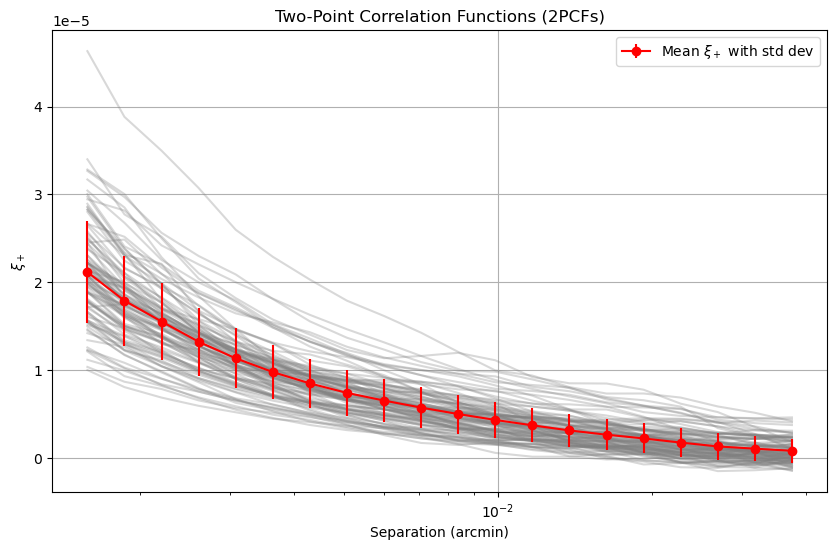

In [22]:
plt.figure(figsize=(10, 6))

# Plot individual xi_+ 2PCFs in grey
for i in range(xip_arr.shape[0]):
    plt.plot(rnom_values_1, xip_arr[i], color='grey', alpha=0.3)

# Plot mean xi_+ with error bars in red
plt.errorbar(rnom_values_1, xip_mean_1, yerr=xip_std_1, fmt='o-', color='red', label=r'Mean $\xi_+$ with std dev')

plt.xscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_+$')
plt.title('Two-Point Correlation Functions (2PCFs)')
plt.legend()
plt.grid(True)
plt.show()

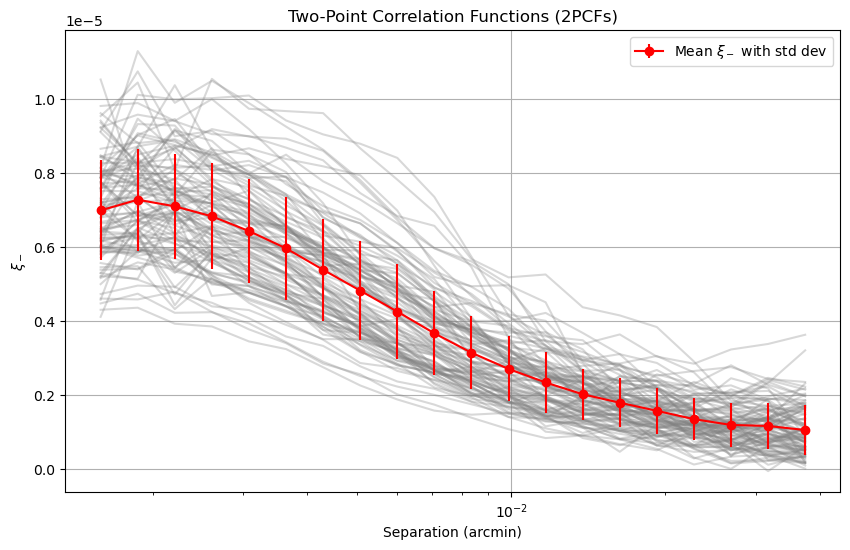

In [23]:
plt.figure(figsize=(10, 6))

# Plot individual xi_+ 2PCFs in grey
for i in range(xip_arr.shape[0]):
    plt.plot(rnom_values_1, xim_arr[i], color='grey', alpha=0.3)

# Plot mean xi_+ with error bars in red
plt.errorbar(rnom_values_1, xim_mean_1, yerr=xim_std_1, fmt='o-', color='red', label=r'Mean $\xi_-$ with std dev')

plt.xscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_-$')
plt.title('Two-Point Correlation Functions (2PCFs)')
plt.legend()
plt.grid(True)
plt.show()

------------------------------------------------------------------------------------------------------------------------------------------------------

# P2.6

Number of pixels: 50331648
NSIDE: 2048


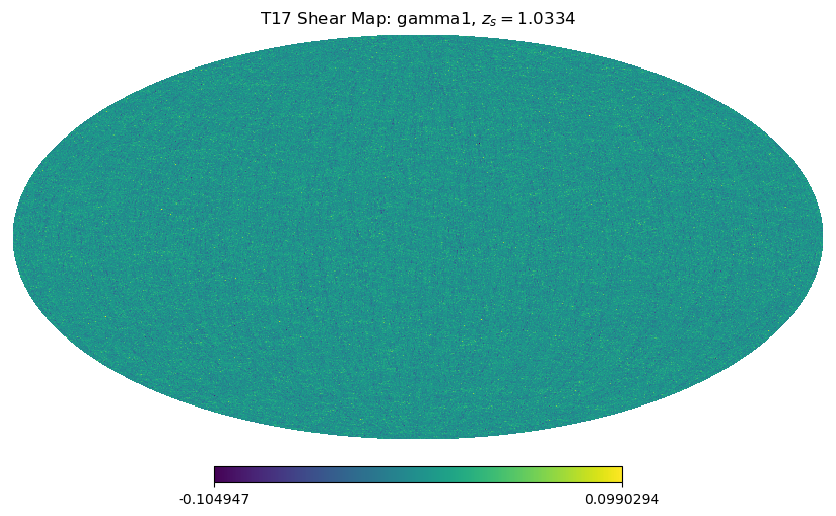

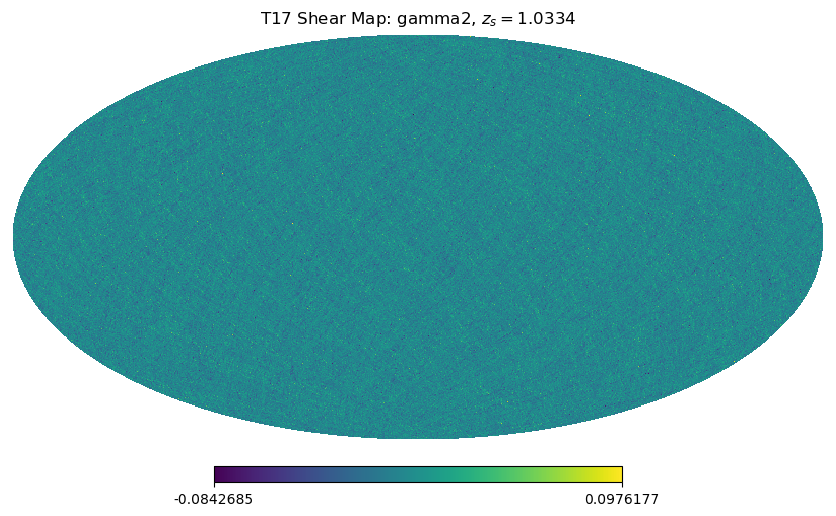

gamma1_disc_2 =  [ 0.00134303  0.01000046  0.01228451 ... -0.00480248 -0.00741868
 -0.00672033]
gamma2_disc_2 =  [ 0.005542   -0.00765275  0.0006923  ... -0.00240034  0.00379684
 -0.00534201]
Tree catalog created with 23955 objects
xip_arr shape: (100, 20)
xim_arr shape: (100, 20)


In [24]:
gamma1_file_2 = "T17_simulation_WL_shear_data/allskymap_NSIDE2048_r000_zsource_1.0334_gamma1.fits"
gamma2_file_2 = "T17_simulation_WL_shear_data/allskymap_NSIDE2048_r000_zsource_1.0334_gamma2.fits"

# Load the maps using healpy
gamma1_map_2 = hp.read_map(gamma1_file_2)
gamma2_map_2 = hp.read_map(gamma2_file_2)

# Check the number of pixels and corresponding NSIDE
npix = len(gamma1_map_2)
nside = hp.npix2nside(npix)
print(f"Number of pixels: {npix}")
print(f"NSIDE: {nside}")

# Visualize the maps
hp.mollview(gamma1_map_2, title="T17 Shear Map: gamma1, $z_s=1.0334$")
plt.show()

hp.mollview(gamma2_map_2, title="T17 Shear Map: gamma2, $z_s=1.0334$")
plt.show()

def pixel2RaDec(pixel_indices, NSIDE):
    theta, phi = hp.pixelfunc.pix2ang(NSIDE, pixel_indices, nest=False, lonlat=False)
    ra = phi
    dec = np.pi/2.0-theta
    return ra, dec
ra_rad, dec_rad = pixel2RaDec(pix_in_disc, NSIDE_fix)
#ra_deg = np.degrees(ra_rad)
#dec_deg = np.degrees(dec_rad)
# associated gamma1 and gamma2 from extracted pixels
gamma1_disc_2 = gamma1_map_2[pix_in_disc]
gamma2_disc_2 = gamma2_map_2[pix_in_disc]

print("gamma1_disc_2 = ", gamma1_disc_2)
print("gamma2_disc_2 = ", gamma2_disc_2)


cat_2 = treecorr.Catalog(ra = ra_rad, dec = dec_rad, g1=gamma1_disc_2, g2 = gamma2_disc_2, ra_units='rad', dec_units='rad', flip_g1=True)


min_sep = 5
max_sep = 140
nbins = 20
gg_2 = treecorr.GGCorrelation(min_sep = 5*np.pi/(180*60), max_sep = 140*np.pi/(180*60),nbins = 20 ,sep_units = 'radians')
gg_2.process(cat_2)


print("Tree catalog created with", cat_2.nobj, "objects")
xip_values_2 = gg_2.xip
xim_values_2 = gg_2.xim

rnom_values_2 = gg_2.rnom 

fig, ax = plt.subplots()

plt.plot(rnom_values_2, xip_values_2, c='r', label=r'$\xi_{+}$')
plt.plot(rnom_values_2, xim_values_2, c='b', label=r'$\xi_{-}$')

plt.title('Shear correlation function')
plt.xlabel('Separation (in arcminutes)')
plt.ylabel('Correlation')
plt.legend(loc='upper right')
plt.grid(True)

n_patches = 100
nbins = 20

# Arrays to store results
xip_arr = np.zeros((n_patches, nbins))
xim_arr = np.zeros((n_patches, nbins))

# Randomly select patch centers (latitude in [-87.5, 87.5] to avoid poles)
rng = np.random.default_rng(seed=42)
latitudes = rng.uniform(-87.5, 87.5, n_patches)
longitudes = rng.uniform(0, 360, n_patches)

for i in range(n_patches):
    lat = latitudes[i]
    lon = longitudes[i]
    vec = hp.ang2vec(lon, lat, lonlat=True)
    pix_in_disc = hp.query_disc(NSIDE_fix, vec, radius_rad, inclusive=False)

    # Convert pixel indices to RA/Dec (degrees)
    theta, phi = hp.pix2ang(NSIDE_fix, pix_in_disc, lonlat=False)
    ra = phi
    dec = 0.5 * np.pi - theta

    # Extract shear values for the patch
    g1_2 = gamma1_map_2[pix_in_disc]
    g2_2 = gamma2_map_2[pix_in_disc]

    # Build TreeCorr catalog
    cat_2 = treecorr.Catalog(ra=ra, dec=dec, g1=g1_2, g2=g2_2, ra_units='rad', dec_units='rad', flip_g1=True)
    gg_2 = treecorr.GGCorrelation(min_sep = 5*np.pi/(180*60), max_sep = 140*np.pi/(180*60),nbins = 20 ,sep_units = 'radians')
    gg_2.process(cat_2)

    xip_arr[i, :] = gg_2.xip
    xim_arr[i, :] = gg_2.xim

print("xip_arr shape:", xip_arr.shape)
print("xim_arr shape:", xim_arr.shape)

In [25]:
xip_mean_2 = np.mean(xip_arr, axis=0)
xip_std_2 = np.std(xip_arr, axis=0)
xim_mean_2 = np.mean(xim_arr, axis=0)
xim_std_2 = np.std(xim_arr, axis=0)

print("Mean xi_+:", xip_mean_2)
print("Std xi_+:", xip_std_2)
print("Mean xi_-:", xim_mean_2)
print("Std xi_-:", xim_std_2)

Mean xi_+: [5.85093674e-05 5.01725861e-05 4.39999146e-05 3.81946789e-05
 3.31715647e-05 2.89664425e-05 2.53536592e-05 2.21253964e-05
 1.93162493e-05 1.68075243e-05 1.45335476e-05 1.24762461e-05
 1.06718861e-05 8.94258368e-06 7.47556420e-06 6.18744323e-06
 4.82339250e-06 3.62661428e-06 2.86050884e-06 2.22471461e-06]
Std xi_+: [1.12689601e-05 1.05031316e-05 9.52074520e-06 8.81418465e-06
 8.35003786e-06 7.89103245e-06 7.52816231e-06 7.21011132e-06
 6.77923563e-06 6.48666175e-06 6.24816265e-06 6.08916524e-06
 5.74358615e-06 5.49975341e-06 5.22950898e-06 4.91960853e-06
 4.64483969e-06 4.25698372e-06 4.10435956e-06 4.04062180e-06]
Mean xi_-: [2.30477378e-05 2.29079366e-05 2.16284085e-05 2.01887399e-05
 1.84129696e-05 1.66289369e-05 1.48310236e-05 1.30647084e-05
 1.14325651e-05 9.98902725e-06 8.69893914e-06 7.65621412e-06
 6.73737827e-06 5.86103043e-06 5.25640391e-06 4.59855032e-06
 3.99324239e-06 3.55196359e-06 3.39559636e-06 3.06847016e-06]
Std xi_-: [3.05596088e-06 2.80520991e-06 2.9465367

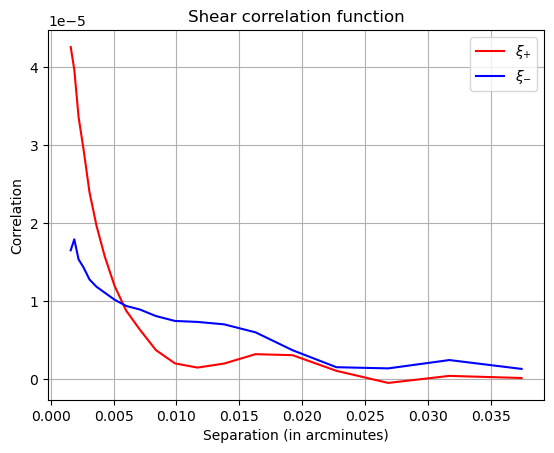

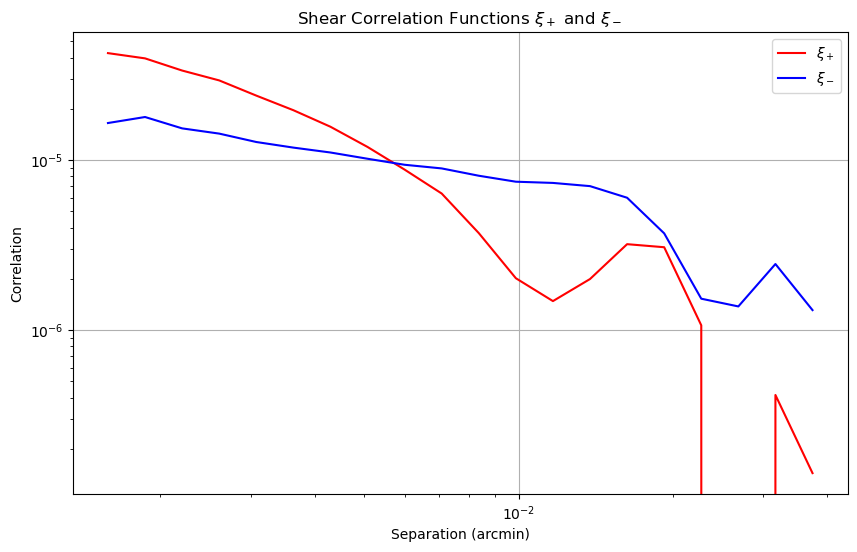

In [26]:
#gg.xip and gg.xim are correlation values eta+ eta-
xip_values_2 = gg_2.xip
xim_values_2 = gg_2.xim
rnom_values_2 = gg_2.rnom # gives normal bin centers (angular seperations)
#correlation function v/s angular separations
plt.figure(figsize=(10,6))
plt.plot(rnom_values_2, xip_values_2 ,c='r', label=r'$\xi_+$')
plt.plot(rnom_values_2, xim_values_2, c='b', label=r'$\xi_-$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel('Correlation')
plt.title('Shear Correlation Functions $\\xi_+$ and $\\xi_-$')
plt.legend()
plt.grid(True)
plt.show()
#If your selected patch is small or contains random shear values (as can happen in a small disc or a
#region with little signal), the correlation functions eta+and eta− will average to zero.

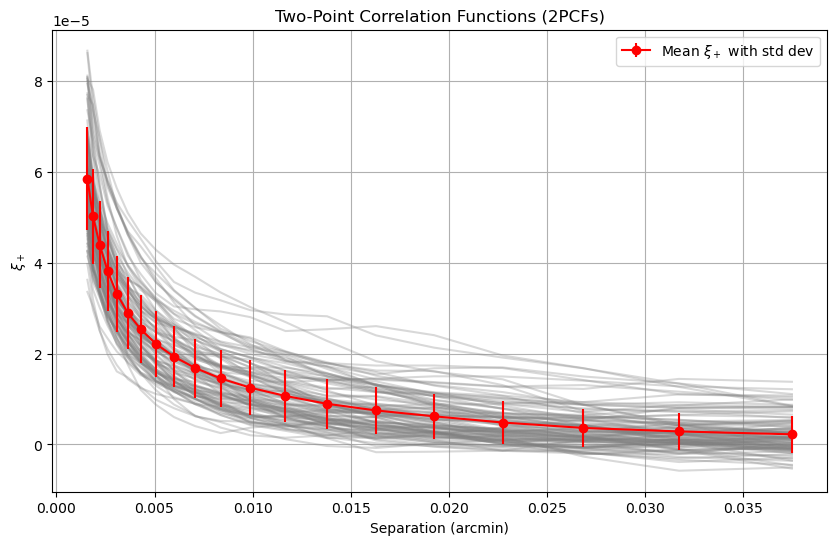

In [27]:
plt.figure(figsize=(10, 6))

# Plot individual xi_+ 2PCFs in grey
for i in range(xip_arr.shape[0]):
    plt.plot(rnom_values_2, xip_arr[i], color='grey', alpha=0.3)
    3#plt.xscale('log')
    #plt.yscale('log')

# Plot mean xi_+ with error bars in red
plt.errorbar(rnom_values_2, xip_mean_2, yerr=xip_std_2, fmt='o-', color='red', label=r'Mean $\xi_+$ with std dev')

# plt.xscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_+$')
plt.title('Two-Point Correlation Functions (2PCFs)')
plt.legend()
plt.grid(True)
plt.show()

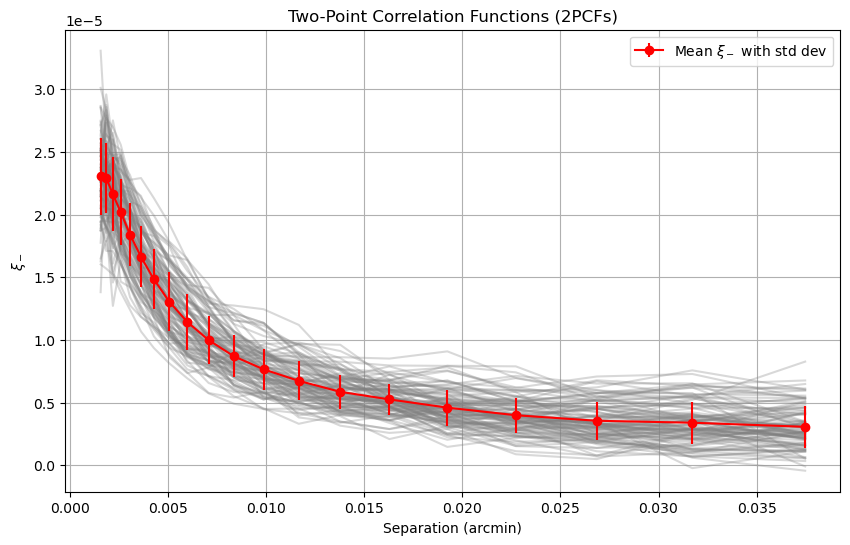

In [28]:
plt.figure(figsize=(10,6))

# Plot individual xi_+ 2PCFs in grey
for i in range(xim_arr.shape[0]):
    plt.plot(rnom_values_2, xim_arr[i], color='grey', alpha=0.3)

# Plot mean xi_+ with error bars in red
plt.errorbar(rnom_values_2, xim_mean_2, yerr=xim_std_2, fmt='o-', color='red', label=r'Mean $\xi_-$ with std dev')
    
#plt.xscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_-$')
plt.title('Two-Point Correlation Functions (2PCFs)')
plt.legend()
plt.grid(True)
plt.show()

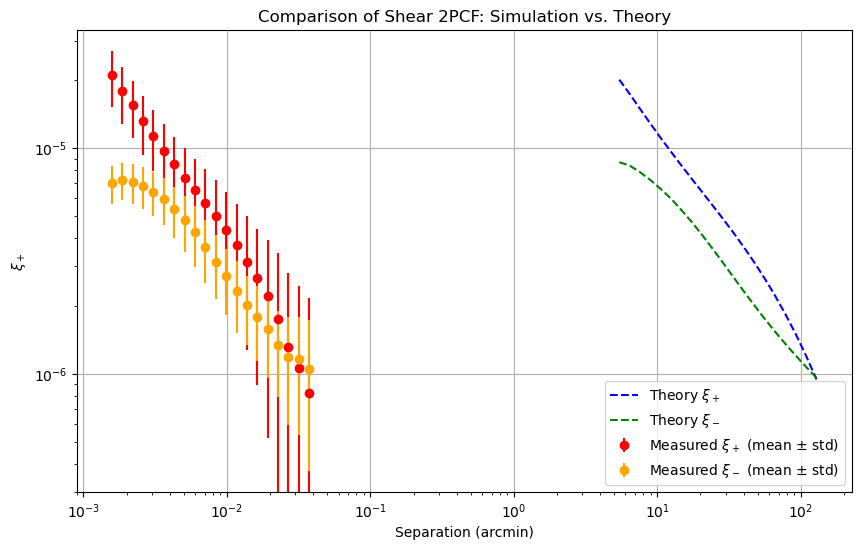

In [29]:
# Load your theoretical model values (from .txt or .dat)
theory_data = np.loadtxt('shear_2pcf_values.txt')
theta_model = theory_data[:, 0]
xip_model = theory_data[:, 1]
xim_model = theory_data[:, 2]

# Assume you have already computed these from your simulation patches:
# rnom: bin centers (arcmin), xip_mean, xip_std
# If you have both z_s1 and z_s2, repeat for each

# Example placeholders (replace with your actual measured data)
# rnom = ... (your bin centers)
# xip_mean = ... (your measured mean xi_+)
# xip_std = ... (your measured std xi_+)

plt.figure(figsize=(10, 6))

# Plot measured mean xi_+ with error bars
plt.errorbar(rnom_values_1, xip_mean_1, yerr=xip_std_1, fmt='o', color='red', label=r'Measured $\xi_+$ (mean $\pm$ std)')

# Plot theoretical xi_+ curve
plt.plot(theta_model, xip_model, 'b--', label=r'Theory $\xi_+$')

plt.errorbar(rnom_values_1, xim_mean_1, yerr=xim_std_1, fmt='o', color='orange', label=r'Measured $\xi_-$ (mean $\pm$ std)')

# Plot theoretical xi_+ curve
plt.plot(theta_model, xim_model, 'g--', label=r'Theory $\xi_-$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_+$')
plt.title('Comparison of Shear 2PCF: Simulation vs. Theory')
plt.legend()
plt.grid(True)
plt.show()

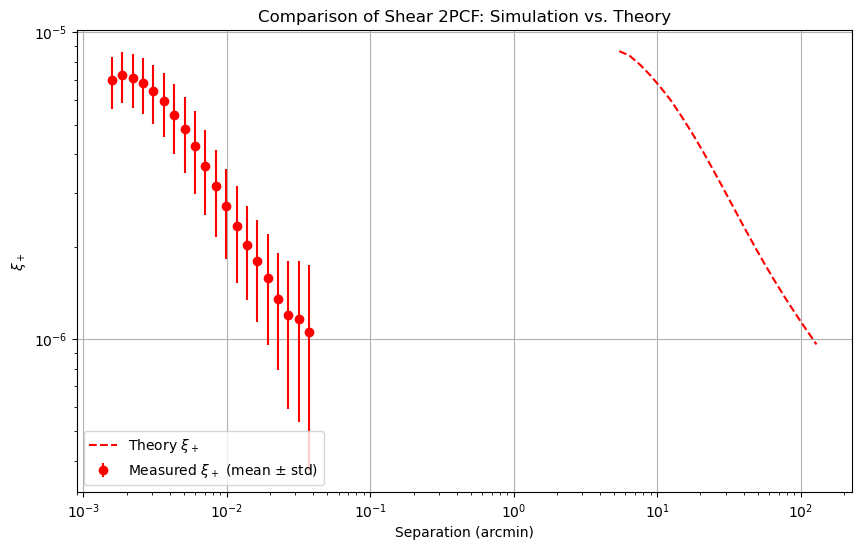

In [30]:
# Assume you have already computed these from your simulation patches:
# rnom: bin centers (arcmin), xip_mean, xip_std
# If you have both z_s1 and z_s2, repeat for each

# Example placeholders (replace with your actual measured data)
# rnom = ... (your bin centers)
# xip_mean = ... (your measured mean xi_+)
# xip_std = ... (your measured std xi_+)

plt.figure(figsize=(10, 6))

# Plot measured mean xi_+ with error bars
plt.errorbar(rnom_values_1, xim_mean_1, yerr=xim_std_1, fmt='o', color='red', label=r'Measured $\xi_+$ (mean $\pm$ std)')

# Plot theoretical xi_+ curve
plt.plot(theta_model, xim_model, 'r--', label=r'Theory $\xi_+$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_+$')
plt.title('Comparison of Shear 2PCF: Simulation vs. Theory')
plt.legend()
plt.grid(True)
plt.show()

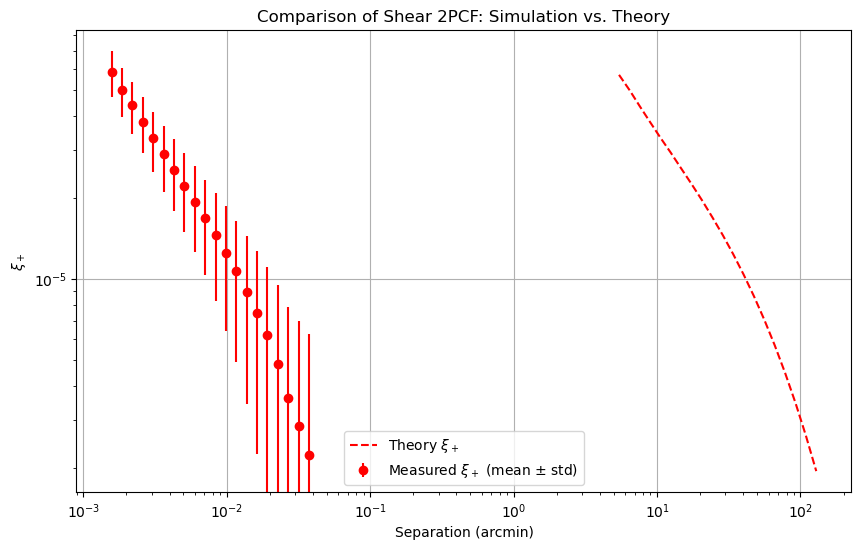

In [31]:
# Load your theoretical model values (from .txt or .dat)
theory_data_2 = np.loadtxt('shear_2pcf_values_2.txt')
theta_model_2 = theory_data_2[:, 0]
xip_model_2 = theory_data_2[:, 1]
xim_model_2 = theory_data_2[:, 2]

# Assume you have already computed these from your simulation patches:
# rnom: bin centers (arcmin), xip_mean, xip_std
# If you have both z_s1 and z_s2, repeat for each

# Example placeholders (replace with your actual measured data)
# rnom = ... (your bin centers)
# xip_mean = ... (your measured mean xi_+)
# xip_std = ... (your measured std xi_+)

plt.figure(figsize=(10, 6))

# Plot measured mean xi_+ with error bars
plt.errorbar(rnom_values_2, xip_mean_2, yerr=xip_std_2, fmt='o', color='red', label=r'Measured $\xi_+$ (mean $\pm$ std)')

# Plot theoretical xi_+ curve
plt.plot(theta_model_2, xip_model_2, 'r--', label=r'Theory $\xi_+$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_+$')
plt.title('Comparison of Shear 2PCF: Simulation vs. Theory')
plt.legend()
plt.grid(True)
plt.show()

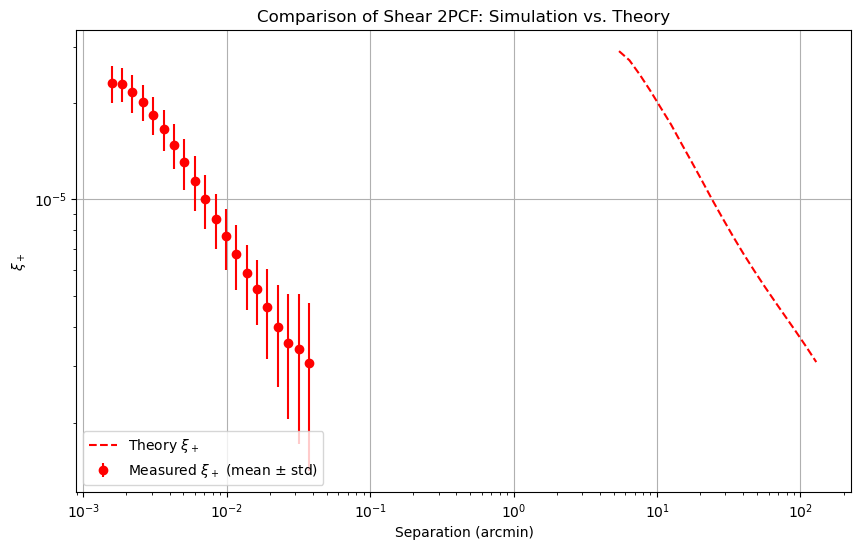

In [32]:
# Assume you have already computed these from your simulation patches:
# rnom: bin centers (arcmin), xip_mean, xip_std
# If you have both z_s1 and z_s2, repeat for each

# Example placeholders (replace with your actual measured data)
# rnom = ... (your bin centers)
# xip_mean = ... (your measured mean xi_+)
# xip_std = ... (your measured std xi_+)

plt.figure(figsize=(10, 6))

# Plot measured mean xi_+ with error bars
plt.errorbar(rnom_values_2, xim_mean_2, yerr=xim_std_2, fmt='o', color='red', label=r'Measured $\xi_+$ (mean $\pm$ std)')

# Plot theoretical xi_+ curve
plt.plot(theta_model_2, xim_model_2, 'r--', label=r'Theory $\xi_+$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Separation (arcmin)')
plt.ylabel(r'$\xi_+$')
plt.title('Comparison of Shear 2PCF: Simulation vs. Theory')
plt.legend()
plt.grid(True)
plt.show()